In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import pickle

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location

np.random.seed(42)
pd.set_option('display.max_columns', 999)

# Loading data

In [16]:
ba15 = pd.read_csv('../data/tweets/ba_2015.csv')

In [17]:
ba_shapefiles = gpd.read_file('../data/shapefiles/buenos_aires_shapefiles/BA_2010.shp')
ba_shapefiles = convert_shapefile_crs(ba_shapefiles)

# Filtering data and adding tracts

In [18]:
# Compute summary stats
num_tweets_15, num_users_15, median_tweets_15 = len(ba15), ba15['u_id'].nunique(), ba15.groupby('u_id').size().median()
percentile_99 = ba15.groupby('u_id').size().quantile(.99)

In [19]:
# Filter based on median tweets for 2015
ba15_filtered = ba15.groupby('u_id').filter(lambda group: (len(group) >= median_tweets_15) & (len(group) < percentile_99))

In [20]:
# Geometrize tweets based on lat/lon
ba15_filtered = geometrize_tweets(ba15_filtered)

In [21]:
# Add datetime
ba15_filtered['timestamp'] = pd.to_datetime(ba15_filtered['created_at'] // 1000, unit='s')
ba15_filtered['date'] = ba15_filtered['timestamp'].dt.date
ba15_filtered['hour'] = ba15_filtered['timestamp'].dt.hour

In [22]:
# Spatial join for tracts; add home locations
ba15_filtered = gpd.sjoin(ba15_filtered, ba_shapefiles, how='left', op='intersects')
ba15_filtered['home'] = assign_home_location(ba15_filtered, tract='codigo')
ba15_filtered['is_home'] = ba15_filtered['codigo'] == ba15_filtered['home']

/scratch/public/jsp/twitter-and-displacement/.env/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'proj': 'tmerc', 'lat_0': -34.6297166, 'lon_0': -58.4627, 'k': 1, 'x_0': 100000, 'y_0': 100000, 'ellps': 'intl', 'units': 'm', 'no_defs': True})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [6]:
# Save data for easy loading in future
# with open('../data/ba13_home.pkl', 'wb') as file:
#     pickle.dump(ba13_filtered, file, protocol=4)
with open('../data/ba13_home.pkl', 'rb') as file:
    ba13_filtered = pickle.load(file)
        
ba13_filtered['is_home'] = ba13_filtered['home'] == ba13_filtered['codigo']

In [14]:
# How many of the filtered tweets have a home assignment?
print((~ba13_filtered['home'].isnull()).mean())

0.2476184272985026


In [15]:
# Ratio of users that have home location
ba13_filtered.groupby(['u_id']).first()['is_home'].mean()

0.06805443704191783

In [16]:
# Ratio of filtered 2013 tweets in which tweet was made from home tract 
ba13_filtered['is_home'].mean()

0.12776604536900835

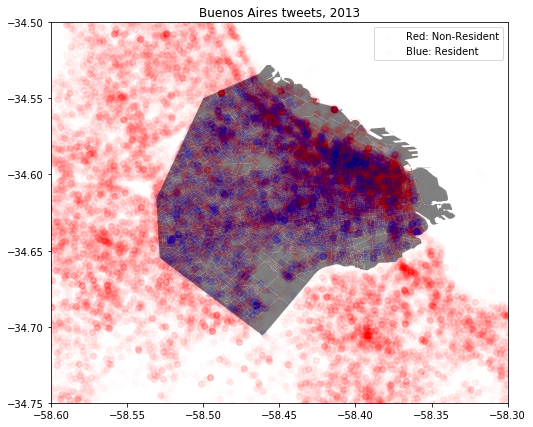

In [17]:
### Plot 1% of 2013 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba13_filtered.sample(frac=0.01, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2013');

# min_hours == 0

In [18]:
# Save data for easy loading in future
# with open('../data/ba13_home.pkl', 'wb') as file:
#     pickle.dump(ba13_filtered, file, protocol=4)
# with open('../data/ba13_home.pkl', 'rb') as file:
#     ba13_filtered = pickle.load(file)

ba13_filtered['home'] = assign_home_location(ba13_filtered, tract='codigo', min_hours=0)
ba13_filtered['is_home'] = ba13_filtered['home'] == ba13_filtered['codigo']

In [19]:
# How many of the filtered tweets have a home assignment?
print((~ba13_filtered['home'].isnull()).mean())

0.2665632878619938


In [20]:
# Ratio of users that have home location
ba13_filtered.groupby(['u_id']).first()['is_home'].mean()

0.07437505592568189

In [21]:
# Ratio of filtered 2013 tweets in which tweet was made from home tract 
ba13_filtered['is_home'].mean()

0.13211512138583167

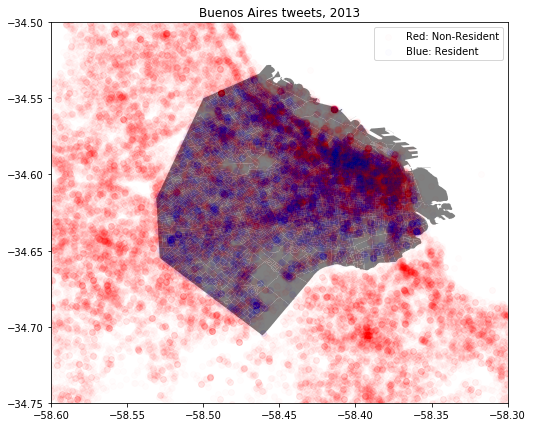

In [22]:
### Plot 1% of 2013 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba13_filtered.sample(frac=0.01, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2013');

In [8]:
(
    ba13_filtered
    .loc[:, ['codigo', 'is_home']]
    .groupby('codigo')
    .agg([len, np.mean])
    .rename(columns={'len':'count', 'mean':'home_tweet_ratio'})
).to_csv('../data/ba13_home_by_codigo.csv')

# Filtered

In [9]:
# Save data for easy loading in future
# with open('../data/ba15_home.pkl', 'wb') as file:
#     pickle.dump(ba15_filtered, file, protocol=4)
# with open('../data/ba15_home.pkl', 'rb') as file:
#     ba15_filtered = pickle.load(file)

ba15_filtered['home'] = assign_home_location(ba15_filtered, tract='codigo')
ba15_filtered['is_home'] = ba15_filtered['home'] == ba15_filtered['codigo']

In [10]:
# How many of the filtered tweets have a home assignment?
print((~ba15_filtered.loc[~ba15_filtered['codigo'].isnull(), 'home'].isnull()).mean())

0.6618643648135882


In [11]:
# Ratio of users that have home location
ba15_filtered[~ba15_filtered['codigo'].isnull()].groupby(['u_id']).first()['is_home'].mean()

0.09331669007125397

In [12]:
# Ratio of filtered 2015 tweets in which tweet was made from home tract 
ba15_filtered.loc[~ba15_filtered['codigo'].isnull(), 'is_home'].mean()

0.4429316438771657

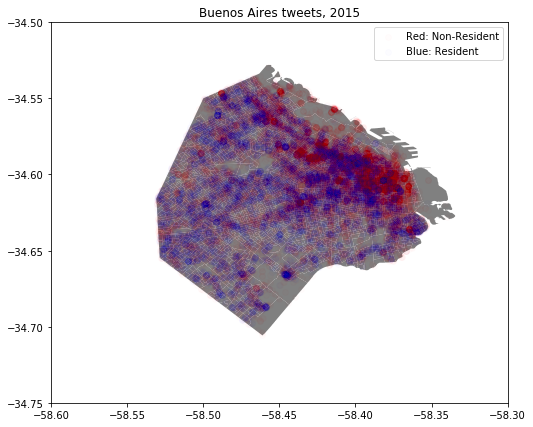

In [13]:
### Plot 1% of 2015 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba15_filtered[~ba15_filtered['codigo'].isnull()].sample(frac=0.01, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2015');

In [14]:
(
    ba15_filtered
    .loc[:, ['codigo', 'is_home']]
    .groupby('codigo')
    .agg([len, np.mean])
    .rename(columns={'len':'count', 'mean':'home_tweet_ratio'})
).to_csv('../data/ba15_home_by_codigo_99_removed.csv')

In [23]:
def save_data(data, year):
    parque = data[(data['BARRIOS'] == 'PARQUE PATRICIOS') | 
                  (data['codigo'].isin([20041001, 20012905, 20032309]))]
    boca = data[(data['BARRIOS'] == 'BOCA') & (data['codigo'] != 20041801)]
    
    parque.to_csv('../ba_' + str(year) + '_PARQUE_PATRICIOS.csv', index=False)
    boca.to_csv('../ba_' + str(year) + '_BOCA.csv', index=False)

In [24]:
save_data(ba15_filtered, 2015)